In [9]:
# 验证路径设置
%matplotlib inline
import os
import sys
from pathlib import Path

# 自动计算项目根目录
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))  
if project_root not in sys.path:
    sys.path.insert(0, project_root)

    
# 打印当前环境路径
print(f"Python executable: {sys.executable}")
print(f"Project root: {project_root}")
# 导入模块

try:
    from config.tickers import NASDAQ_100
    from config.NASDAQ_100_Chinese  import NASDAQ_100_Chinese
    from importnb import Notebook
    from openai import OpenAI 
    from dotenv import load_dotenv
    from IPython import get_ipython
    load_dotenv()  # 自动加载.env文件
    with Notebook():
        from src.visualization import plot_technical
        from src.downloader import download_stock_data
    print("✅ 模块导入成功！")
except ImportError as e:
    print(f"❌ 导入失败: {str(e)}")
    print("当前 Python 路径：", sys.path)


Python executable: c:\Users\theli\Documents\GitHub\stock_project\.venv\Scripts\python.exe
Project root: c:\Users\theli\Documents\GitHub\stock_project
✅ 模块导入成功！


In [10]:
# 下载股票数据
start_date = '2025-10-01'
end_date = '2025-12-31'
period = '3mo'
interval = '1h'
ticker = ['MP']

df = download_stock_data( ticker , start_date , end_date , period=period, interval=interval)
df.head()

[*********************100%***********************]  1 of 1 completed
c:\Users\theli\Documents\GitHub\stock_project\src\downloader.ipynb:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Volume'] = df['Volume'].replace(0, np.nan).fillna(method='ffill')  # 处理成交量为0的情况


,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI
Datetime,,,,,,,,,,,,
2025-08-12 14:30:00+00:00,73.669998,75.370003,73.059998,74.730003,NaN,NaN,NaN,3.161792,NaN,NaN,NaN,NaN
2025-08-12 15:30:00+00:00,74.769997,74.878502,72.639999,73.019997,1467021.0,-2.288247,-0.023148,3.081639,NaN,NaN,NaN,NaN
2025-08-12 16:30:00+00:00,73.046997,73.449997,72.680000,72.931999,735285.0,-0.120511,-0.001206,1.059434,NaN,NaN,NaN,NaN
2025-08-12 17:30:00+00:00,72.910004,73.180000,72.139999,72.949997,1117232.0,0.024677,0.000247,1.441643,NaN,NaN,NaN,NaN
2025-08-12 18:30:00+00:00,72.900002,73.800003,72.800003,73.660004,978102.0,0.973279,0.009686,1.373626,NaN,NaN,NaN,NaN


c:\Users\theli\Documents\GitHub\stock_project\src\visualization.ipynb:213: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad = 0.1)


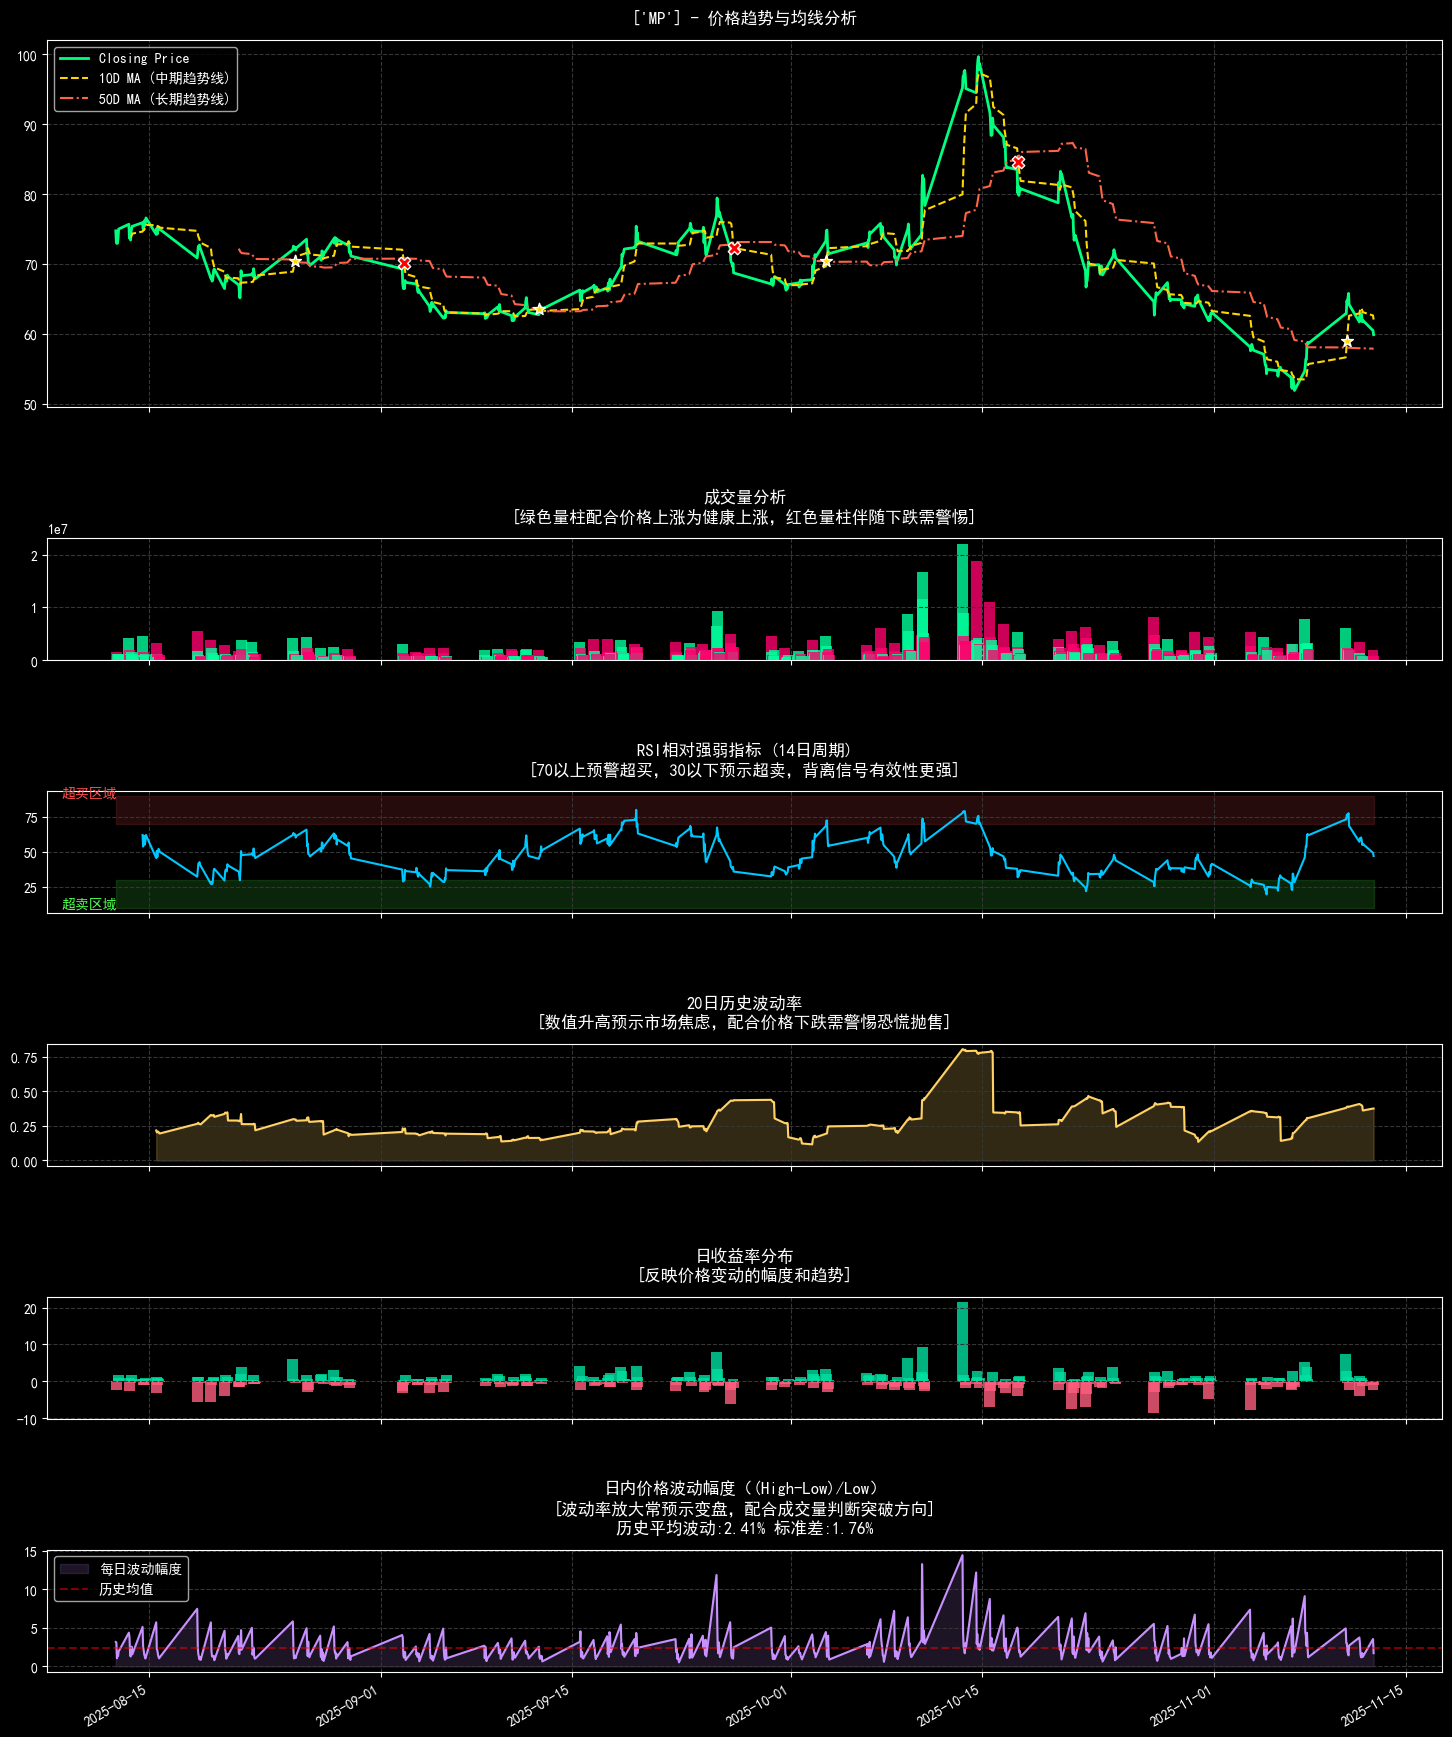

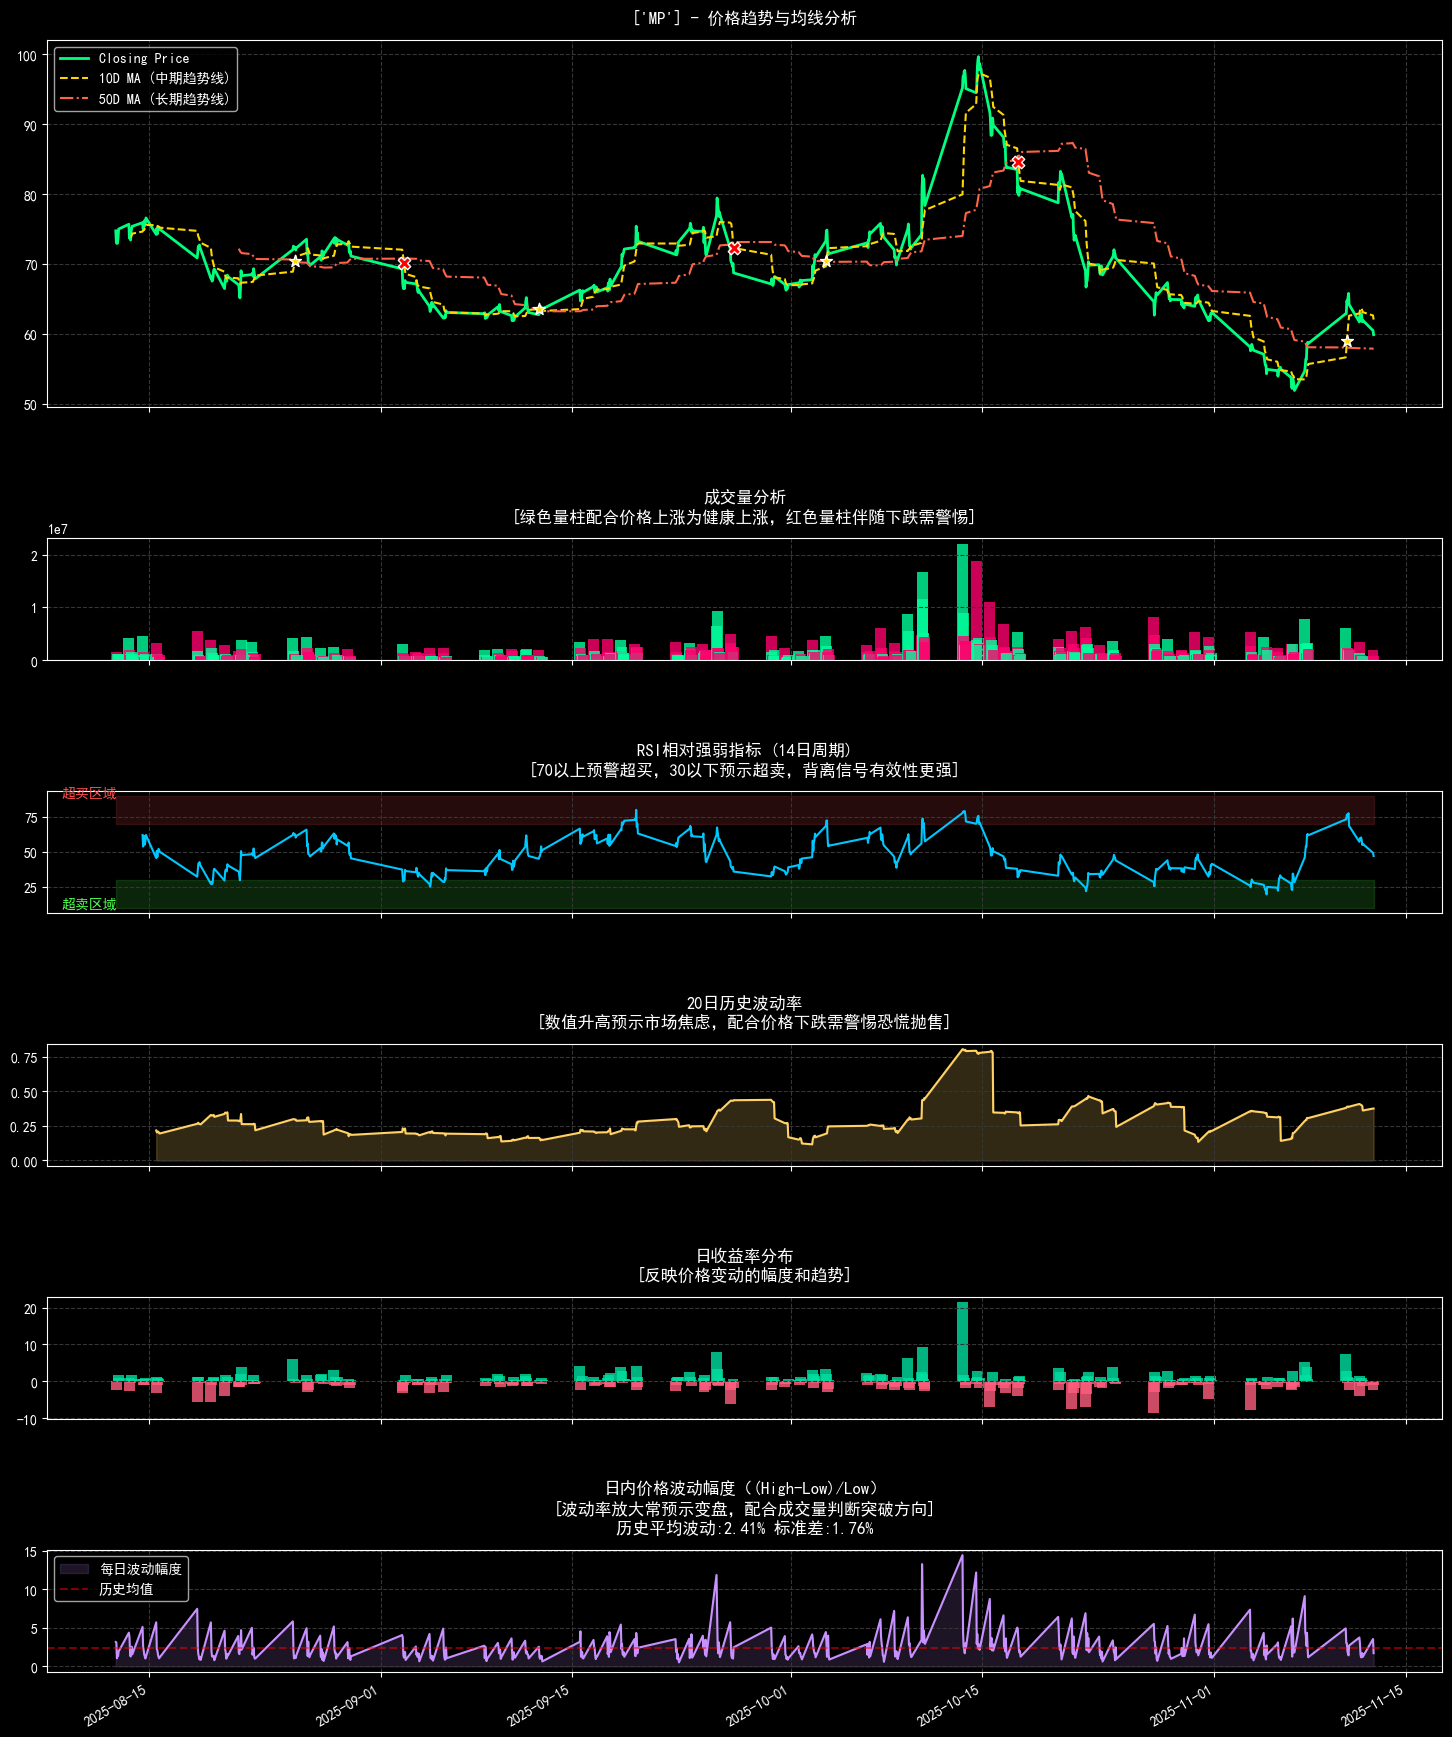

In [11]:
plot_technical(df,ticker)

In [12]:
def get_deepseek_analysis(df, model="deepseek-r1-250120"):
    """
    智能生成股票技术面分析报告和预测未来趋势
    输入：预处理后的美股数据
    输出：deepseek的回答，不包含思考过程
    """
    
    from dotenv import load_dotenv
    load_dotenv()
    # 1、股票数据
    latest = df
        # 提取元数据
    start_date = df.index.min()
    end_date = df.index.max()

    # 生成数据摘要
    data_summary = f"""
    收盘价范围：${df['Close'].min():.2f} - ${df['Close'].max():.2f}
    平均成交量：{df['Volume'].mean():,.0f} 手
    近期波动率：{df['Close'].pct_change().std():.2%}（过去20日）
    """
    
    # 步骤2：构建专业分析提示词
    analysis_prompt = f"""你是美股投资专家，这是{ticker}从{start_date}到{end_date}的交易数据，
    请用简单专业的语言分析{ticker[0]}的走势及其多/空投资机会：
    {latest}
    """
    
    # 步骤3：调用Deepseek API并解析结果
    # try:
    notebook_path = get_ipython().config["IPKernelApp"]["connection_file"].split("\\")[-2]
    project_root = Path(notebook_path).resolve().parent.parent# 动态构建项目路径 
    client = OpenAI(
            api_key='sk-svlwkvpmiesxltcrmogahgwdpsucauiqdvdrgssmogbtujvh',
            base_url='https://api.siliconflow.cn/v1'
            )
    
    completion = client.chat.completions.create(
        model="deepseek-ai/DeepSeek-R1",
        messages=[
            {"role": "user", "content": analysis_prompt}
        ],
        max_tokens = 8192,
        temperature = 0.3
    )
    # 解析响应
    response_message = completion.choices[0].message

    # 提取回答和思考内容
    answer = response_message.content
    reasoning = response_message.reasoning_content

    # 格式化输出，只显示回答，不显示思考
    formatted_output = f'回答：{answer.strip()}'

    # 打印结果
    return print(data_summary + "\n" + formatted_output)
        
    # except Exception as e:
    #     print(f"模型调用失败: {str(e)}")
    #     return "暂无分析结果"

In [13]:
get_deepseek_analysis(df)


    收盘价范围：$51.89 - $99.67
    平均成交量：1,934,829 手
    近期波动率：2.11%（过去20日）
    
回答：### MP股票走势分析（2025-08-12至2025-11-12）

#### **整体趋势**
1. **显著下跌趋势**：
   - 期初价格：$74.73（2025-08-12）
   - 期末价格：$59.88（2025-11-12）
   - **累计跌幅达19.9%**，空头主导市场。

2. **关键技术指标**：
   - **均线系统**：早期MA10持续低于MA50（死叉），但近期MA10上穿MA50（金叉）。然而，金叉后价格未上涨，反而加速下跌（11月12日单日跌2.4%），形成**“假金叉”陷阱**，反映空头力量强劲。
   - **RSI**：最新值47（接近超卖但未触底），显示下行仍有空间。
   - **波动率**：维持在0.35-0.40高位，预示价格波动剧烈。

3. **量能变化**：
   - 下跌末期显著放量（如11月12日成交量196万，远高于前期均值），验证空头抛压加剧。

---

#### **多空投资机会**
##### **空头机会（高置信度）**
1. **顺势做空**：
   - **入场点**：反弹至短期阻力位（如MA10≈$62.0或前低$60.5）时做空。
   - **目标**：$58.0（前低心理关口），跌破可看$55.0。
   - **止损**：日线收盘价站上$61.0（突破近期震荡平台）。

2. **技术依据**：
   - 假金叉 + 放量破位：11月12日长阴线确认下跌延续。
   - 波动率高位：适合趋势跟踪策略。

##### **多头机会（谨慎观望）**
1. **博反弹条件**：
   - 需等待**RSI<30超卖** + **长下影线**反转K线。
   - 若价格企稳$58.0并放量回升，可轻仓试多。
   
2. **风险提示**：
   - 逆势操作风险高，止损必须严格（如$58.0破位立即离场）。

---

### **关键图表信号**
| 日期               | 事件                | 信号意义               |
|--------------------|--

In [14]:
df.head()

,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI,MA10_above_MA50
Datetime,,,,,,,,,,,,,
2025-08-12 14:30:00+00:00,73.669998,75.370003,73.059998,74.730003,NaN,NaN,NaN,3.161792,NaN,NaN,NaN,NaN,False
2025-08-12 15:30:00+00:00,74.769997,74.878502,72.639999,73.019997,1467021.0,-2.288247,-0.023148,3.081639,NaN,NaN,NaN,NaN,False
2025-08-12 16:30:00+00:00,73.046997,73.449997,72.680000,72.931999,735285.0,-0.120511,-0.001206,1.059434,NaN,NaN,NaN,NaN,False
2025-08-12 17:30:00+00:00,72.910004,73.180000,72.139999,72.949997,1117232.0,0.024677,0.000247,1.441643,NaN,NaN,NaN,NaN,False
2025-08-12 18:30:00+00:00,72.900002,73.800003,72.800003,73.660004,978102.0,0.973279,0.009686,1.373626,NaN,NaN,NaN,NaN,False


In [15]:
def generate_report(ticker,start_date,end_date, period=None):
    import matplotlib.pyplot as plt
    
    df = download_stock_data([ticker], start_date, end_date, period)
    analysis_text = get_deepseek_analysis(df)
    fig = plot_technical(df,ticker)
    
    return plt.show(fig) ,analysis_text


In [16]:
generate_report(ticker,start_date,end_date, period=period)

TypeError: expected string or bytes-like object, got 'list'